# Testing behavioural performance of DAGs

## Setup

In [41]:
FORCE_CPU = False
SEED = 2384
MODEL_NAME = "gelu-1l"

OPEN_PAREN_STR_TOKENS = ["("]
CLOSE_PAREN_STR_TOKENS = [")"]
SUPPRESSING_STR_TOKENS = ["(", "_", ",", "+", "."]

DATA_FILES = {
    "single_line": "../../data/paren-balancing/single_line.csv",
    "synthetic": "../../data/paren-balancing/synthetic_1.csv",
}

SAVE_MODEL_PREDICTIONS = False
LOAD_MODEL_PREDICTIONS = True
MODEL_PREDICTIONS_DATA_FILE = "../saved_data/model_predictions.pt"

DATASET_MAX_SIZE = 10000

DAG_BATCH_SIZE = 10000
MODEL_BATCH_SIZE = 64

In [37]:
from IPython.display import display

import random

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import plotly.express as px

from rich.table import Table
from rich.console import Console

from tqdm import tqdm

from transformer_lens import HookedTransformer
from transformer_lens.utils import to_numpy

from causal_networks.dag import (
    DAGModel,
    InputNode,
    GreaterThanZeroNode,
    InSetOutSetNode,
    CumSumNode,
)
from causal_networks.predefined_models import make_basic_pb_dag
from causal_networks.variable_alignment import TransformerVariableAlignment

In [4]:
if not FORCE_CPU and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


## Load model, DAGs and datasets

In [5]:
model = HookedTransformer.from_pretrained(MODEL_NAME, device=device)

Loaded pretrained model gelu-1l into HookedTransformer


In [23]:
open_paren_tokens = model.to_tokens(
    OPEN_PAREN_STR_TOKENS, prepend_bos=False, move_to_device=False, truncate=False
)
open_paren_tokens = [
    open_paren_tokens[i, 0].item() for i in range(open_paren_tokens.shape[0])
]

closed_paren_tokens = model.to_tokens(
    CLOSE_PAREN_STR_TOKENS, prepend_bos=False, move_to_device=False, truncate=False
)
closed_paren_tokens = [
    closed_paren_tokens[i, 0].item() for i in range(closed_paren_tokens.shape[0])
]

suppressing_tokens = model.to_tokens(
    SUPPRESSING_STR_TOKENS, prepend_bos=False, move_to_device=False, truncate=False
)
suppressing_tokens = [
    suppressing_tokens[i, 0].item() for i in range(suppressing_tokens.shape[0])
]

print("Open paren tokens:", open_paren_tokens)
print("Closed paren tokens:", closed_paren_tokens)
print("Suppressing tokens:", suppressing_tokens)

Open paren tokens: [10]
Closed paren tokens: [11]
Suppressing tokens: [10, 65, 14, 13, 16]


In [25]:
def output_modifier(y: torch.tensor):
    binary_output = torch.empty(*y.shape[:-1], 2, device=y.device)
    binary_output[..., 0] = y[..., open_paren_tokens].sum(dim=-1)
    binary_output[..., 1] = y[..., closed_paren_tokens].sum(dim=-1)
    return F.softmax(binary_output, dim=-1)

In [6]:
dags = {"basic": make_basic_pb_dag(model, device=device)}

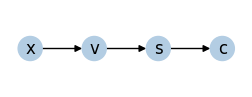

                  Node Information                   
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Node ┃ Module                                     ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ x    │ InputNode()                                │
│ v    │ InSetOutSetNode(in_set=[10], out_set=[11]) │
│ s    │ CumSumNode(dim=-1)                         │
│ c    │ GreaterThanZeroNode()                      │
└──────┴────────────────────────────────────────────┘

In [7]:
for name, dag in dags.items():
    dag.visualize(display_node_table=True)

In [16]:
datasets = {}
for name, dataset_filename in DATA_FILES.items():
    df = pd.read_csv(dataset_filename)
    df = df.sample(frac=1, random_state=SEED)
    df = df[:DATASET_MAX_SIZE]
    datasets[name] = df
    display(datasets[name].head().style.set_caption(name))

,text
289,grad_d = load(grad_d_file).2
18605,melt_value_vars = [c for c in df.columns if re.search(
112171,expr_list.append(expr_s)
15500,"self.config_fixture.config(group='cache', enabled=True).1"
37765,report_doc.updated_on = datetime.datetime.now(tz=bson.tz_util.utc)


,text
90144,(p(h(j(V)l)q(R)F(H)n(e(S(m(k)w(
2681,(u)q(A(p(w(b(T(H)l)K)k(r(b)y)C)
61912,(X)C(T(u(j)K(i(U)E(v)Y)T)r)o(g(
51794,(v(X)Q)x(K(S(V)z)F(P)r(f(b(y(h(
16530,(o(T(N)c)w)C(l)h(x)e(u(S(e(e)n(


In [17]:
tokenised_datasets = {}
for name, dataset in datasets.items():
    tokenised_datasets[name] = model.to_tokens(
        dataset["text"].values, move_to_device=False
    )

In [18]:
for name, dataset in tokenised_datasets.items():
    print(name, dataset.shape)

single_line torch.Size([10000, 118])
synthetic torch.Size([10000, 32])


## Test performance

In [29]:
if LOAD_MODEL_PREDICTIONS:
    model_predictions = torch.load(MODEL_PREDICTIONS_DATA_FILE)
else:
    model_predictions = {}
    for name, dataset in tokenised_datasets.items():
        model_predictions[name] = torch.empty(
            tokenised_datasets[name].shape, dtype=torch.int8
        )
        for batch_start in tqdm(
            range(0, len(dataset), MODEL_BATCH_SIZE), desc=f"Model predictions on {name}"
        ):
            batch_slice = slice(batch_start, batch_start + MODEL_BATCH_SIZE)
            batch = dataset[batch_slice].to(device)
            with torch.no_grad():
                model_output = output_modifier(model(batch)).argmax(dim=-1)
            model_predictions[name][batch_slice] = model_output

if SAVE_MODEL_PREDICTIONS:
    torch.save(model_predictions, MODEL_PREDICTIONS_DATA_FILE)

Model predictions on synthetic: 100%|██████████| 157/157 [01:09<00:00,  2.26it/s]


In [33]:
dag_predictions = {}
for dag_name, dag in dags.items():
    dag_predictions[dag_name] = {}
    for dataset_name, dataset in tokenised_datasets.items():
        dag_predictions[dag_name][dataset_name] = torch.empty(
            tokenised_datasets[dataset_name].shape, dtype=torch.int8
        )
        for batch_start in tqdm(
            range(0, len(dataset), DAG_BATCH_SIZE),
            desc=f"DAG predictions for {dag_name} on {dataset_name}",
        ):
            batch_slice = slice(batch_start, batch_start + DAG_BATCH_SIZE)
            batch = dataset[batch_slice].to(device)
            dag_output = dag(dict(x=batch))["c"]
            dag_predictions[dag_name][dataset_name][batch_slice] = dag_output

DAG predictions for basic on single_line:   0%|          | 0/1 [00:00<?, ?it/s]

DAG predictions for basic on synthetic: 100%|██████████| 1/1 [00:00<00:00, 132.88it/s]


In [35]:
dag_accurcies = np.empty((len(dags), len(datasets)))
for i, (dag_name, dag) in enumerate(dags.items()):
    for j, (dataset_name, dataset) in enumerate(datasets.items()):
        dag_accurcies[i, j] = (
            (dag_predictions[dag_name][dataset_name] == model_predictions[dataset_name])
            .to(torch.float32)
            .mean()
            .item()
        )

In [39]:
table = Table(title="DAG accuracies", show_header=True, header_style="bold")
table.add_column("DAG \\ Dataset")
for dataset_name in datasets.keys():
    table.add_column(dataset_name)
for i, dag_name in enumerate(dags.keys()):
    table.add_row(dag_name, *[f"{dag_accurcies[i, j]:.2%}" for j in range(len(datasets))])
    
console = Console()
console.print(table)

              DAG accuracies               
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ DAG \ Dataset ┃ single_line ┃ synthetic ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ basic         │ 36.28%      │ 43.54%    │
└───────────────┴─────────────┴───────────┘